## Implementation of RFUAV-net
efficient CNN method - 1D convolution

In [247]:
import os
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from helper_functions import *
from loading_functions import *

import time

In [2]:
## Import data -  Drone RF
main_folder = '/home/kzhou/Data/DroneRF/'
t_seg = 0.25 #ms
Xs_arr, ys_arr, y4s_arr, y10s_arr = load_dronerf_raw(main_folder, t_seg)

diff 5 file name: 00000L_13.csv


### Apply Model

In [228]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch
import torchvision.models as models
# from torchmetrics import F1Score

In [4]:
dataset = DroneData(Xs_arr, ys_arr)

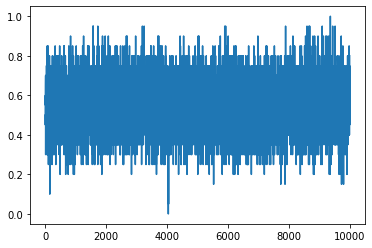

In [5]:
plt.plot(dataset.__getitem__(40)[0][0][1].numpy())

In [213]:
class RFUAVNet(nn.Module):
    #  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(RFUAVNet, self).__init__()
        self.num_classes = num_classes

        self.dense = nn.Linear(320, num_classes)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.smax = nn.Softmax(dim=1)
        
        # for r unit
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=5, stride=5)
        self.norm1 = nn.BatchNorm1d(num_features=64)
        self.elu1 = nn.ELU(alpha=1.0, inplace=False)
        
        # setup for components of the gunit
        self.groupconvlist = []
        self.norm2list = []
        self.elu2list = []
        for i in range(4):
            self.groupconvlist.append( nn.Conv1d( 
                  in_channels=64,
                  out_channels=64,
                  kernel_size=3,
                  stride = 2,
                  groups=8,
    #               bias=False,
                  dtype=torch.float32
                ))
            self.norm2list.append(nn.BatchNorm1d(num_features=64))
            self.elu2list.append(nn.ELU(alpha=1.0, inplace=False))
        self.groupconv = nn.ModuleList(self.groupconvlist)
        self.norm2 = nn.ModuleList(self.norm2list)
        self.elu2 = nn.ModuleList(self.elu2list)
        
        # multi-gap implementation
        self.avgpool1000 = nn.AvgPool1d(kernel_size=1000)
        self.avgpool500 = nn.AvgPool1d(kernel_size=500)
        self.avgpool250 = nn.AvgPool1d(kernel_size=250)
        self.avgpool125 = nn.AvgPool1d(kernel_size=125)
    
    # Progresses data across layers    
    def forward(self, x):
        # runit first
        x1 = self.runit(x
        xg1 = self.gunit(F.pad(x1, (1,0)), 0) 
        x2 = self.pool(x1)
        x3 = xg1+x2
        
        # series of gunits
        xg2 = self.gunit(F.pad(x3, (1,0)), 1)
        x4 = self.pool(x3)
        x5 = xg2+x4
        
        xg3 = self.gunit(F.pad(x5, (1,0)), 2)
        x6 = self.pool(x5)
        x7 = x6+xg3
        
        xg4 = self.gunit(F.pad(x7, (1,0)), 3)
        x8 = self.pool(x7)
        x_togap = x8+xg4
        
        
        # gap and multi-gap
        f_gap_1 = self.avgpool1000(xg1)
        f_gap_2 = self.avgpool500(xg2)
        f_gap_3 = self.avgpool250(xg3)
        f_gap_4 = self.avgpool125(xg4)
        
        f_multigap = torch.cat((f_gap_1,f_gap_2, f_gap_3, f_gap_4), 1)
        
        f_gap_add = self.avgpool125(x_togap)
    
        f_final = torch.cat((f_multigap, f_gap_add),1)
        f_flat = f_final.flatten(start_dim=1)
    
        out = self.dense(f_flat)
#         out = self.smax(f_fc)
        # fc_layer
        
        return out
    
    def runit(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.elu1(x)
        return x
        
    def gunit(self, x, n):
        # group convolution layer 8 by 8
        # norm
        # elu
        # n indicates which gunit
        x = self.groupconv[n](x) 
        x = self.norm2[n](x)
        x = self.elu2[n](x)
        return x

In [ ]:
## Test network
# input1 = dataset.__getitem__(40)[0]
# input1= input1.type(torch.float)
# input = input.reshape(1, 2, 10000)
input1 = torch.rand(128, 2, 10000)

print(input1.shape)

# input_1d = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.float)

net = RFUAVNet(3)
out = net(input1)

# print(out.shape)
# print(out)

In [268]:
# Network Hyperparameters
batch_size = 128 # 128
num_classes = 2
learning_rate = 0.01
num_epochs = 10 # 0
momentum = 0.95
l2reg = 1e-4


In [249]:
# Set up data and parameters

## Set up Data
train_split_percentage = 0.9
split_lengths = [int(train_split_percentage*len(dataset)), len(dataset)-int(train_split_percentage*len(dataset))]
train_set, test_set = torch.utils.data.random_split(dataset, split_lengths)

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                           batch_size = batch_size,
                                           shuffle = True)


## Set up Model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = RFUAVNet(num_classes)
model = model.to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2reg, momentum = momentum)  

total_step = len(train_loader)

In [217]:
# Training
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    for i, (inputs, labels) in enumerate(train_loader): 
        inputs = inputs.float()
        inputs = torch.squeeze(inputs, 1)
        labels = labels.type(torch.long)

        # Move tensors to the configured device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%50 == 49:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [1/3], Loss: 0.6918
Epoch [1/3], Loss: 0.2003
Epoch [1/3], Loss: 0.1485
Epoch [1/3], Loss: 0.0362
Epoch [1/3], Loss: 0.0176
Epoch [1/3], Loss: 0.0451
Epoch [1/3], Loss: 0.0170
Epoch [1/3], Loss: 0.0138
Epoch [1/3], Loss: 0.0153
Epoch [1/3], Loss: 0.0527
Epoch [1/3], Loss: 0.0215
Epoch [1/3], Loss: 0.0172
Epoch [1/3], Loss: 0.0816
Epoch [1/3], Loss: 0.0137
Epoch [1/3], Loss: 0.0152
Epoch [1/3], Loss: 0.0203
Epoch [1/3], Loss: 0.0187
Epoch [1/3], Loss: 0.0097
Epoch [1/3], Loss: 0.0035
Epoch [1/3], Loss: 0.0164
Epoch [1/3], Loss: 0.0048
Epoch [1/3], Loss: 0.0233
Epoch [1/3], Loss: 0.0233
Epoch [1/3], Loss: 0.0045
Epoch [1/3], Loss: 0.0203
Epoch [1/3], Loss: 0.1849
Epoch [1/3], Loss: 0.0276
Epoch [1/3], Loss: 0.0179
Epoch [1/3], Loss: 0.0517
Epoch [1/3], Loss: 0.0047
Epoch [1/3], Loss: 0.0242
Epoch [2/3], Loss: 0.0270
Epoch [2/3], Loss: 0.0162
Epoch [2/3], Loss: 0.0066
Epoch [2/3], Loss: 0.0172
Epoch [2/3], Loss: 0.0118
Epoch [2/3], Loss: 0.0044
Epoch [2/3], Loss: 0.0093
Epoch [2/3],

In [218]:
## Check accuracy
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.float()
        inputs = torch.squeeze(inputs, 1)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))


Accuracy of the network on the 22600 train images: 99.76548672566372 %


In [219]:
get_n_params(model)

8386

## K-fold CV

In [ ]:
# Configuration options
k_folds = 10

# For fold results
results = {}
runtimes = np.zeros(k_folds)
f1s = np.zeros(k_folds)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler)

    # Init the neural network
    network = RFUAVNet(num_classes)
    network = network.to(device)
#     network.apply(reset_weights)

    criterion = nn.CrossEntropyLoss()

    # Initialize optimizer
#     optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=l2reg, momentum = momentum)  

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader):
            # Get inputs
            inputs, targets = data
            inputs = inputs.float()
            inputs = torch.squeeze(inputs, 1) ### TODO put this in the network or dataset
            targets= targets.type(torch.long)
                        
            # Move tensors to configured device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Perform forward pass
            outputs = network(inputs)
            
            # Compute loss            
            loss = criterion(outputs, targets)

            # Zero the gradients
            optimizer.zero_grad()

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            current_loss += loss.item()
            if i % 50 == 49:
                print('    Loss after mini-batch %5d: %.5f' %
                      (i + 1, current_loss / 50))
                current_loss = 0.0
#         print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

    # Process is complete.
#     print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    print('----------------')

    # Saving the model
#     save_path = f'./model-fold-{fold}.pth'
#     torch.save(network.state_dict(), save_path)

    # Evaluation for this fold
    correct, total = 0, 0
    network.eval()
    with torch.no_grad():
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        runtimes_thisfold = []
        f1s_thisfold = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(testloader, 0):
            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Generate outputs
            n_instances = len(inputs)
            ys = torch.empty(n_instances)
            ys = ys.to(device)

            for i in range(n_instances):
                instance = inputs[i]
                instance = instance.float()
                start = time.time()
                starter.record()
                yi = network(instance)
                _,pred = torch.max(yi,1)
                ender.record()
                
                torch.cuda.synchronize()
                curr_time = starter.elapsed_time(ender) #miliseconds

                runtimes_thisfold.append(curr_time*1e-3)
                ys[i] = pred


            # Set total and correct
            total += targets.size(0)
            correct += (ys == targets).sum().item()
            f1i = f1_score(ys.cpu().numpy(), targets.cpu().numpy())
            f1s_thisfold.append(f1i)
            
        mean_runtime = np.mean(np.array(runtimes_thisfold))
        mean_f1 = np.mean(np.array(f1s_thisfold))

    # Summarize and print results
    results[fold] = 100.0 * (correct / total)
    runtimes[fold] = mean_runtime
    f1s[fold] = mean_f1
    print('Accuracy for fold %d: %.2f %%' % (fold, 100.0 * correct / total))
    print('F1 for fold %d: %.2f ' % (fold, mean_f1))
    print('Runtime for fold %d: %.4f s' % (fold, mean_runtime))
    print('--------------------------------')

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average Accuracy: {sum/len(results.items())} %')
print(f'Average F1: {np.mean(f1s)}')
print(f'Average Runtime: {np.mean(runtimes)} s')

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
    Loss after mini-batch    50: 2.65557
    Loss after mini-batch   100: 0.45024
    Loss after mini-batch   150: 0.13409
    Loss after mini-batch   200: 0.09042
    Loss after mini-batch   250: 0.06230
    Loss after mini-batch   300: 0.04751
    Loss after mini-batch   350: 0.04412
    Loss after mini-batch   400: 0.04472
    Loss after mini-batch   450: 0.03279
    Loss after mini-batch   500: 0.03216
    Loss after mini-batch   550: 0.03578
    Loss after mini-batch   600: 0.03071
    Loss after mini-batch   650: 0.03007
    Loss after mini-batch   700: 0.02805
    Loss after mini-batch   750: 0.02710
    Loss after mini-batch   800: 0.02903
    Loss after mini-batch   850: 0.02122
    Loss after mini-batch   900: 0.02665
    Loss after mini-batch   950: 0.01752
    Loss after mini-batch  1000: 0.01682
    Loss after mini-batch  1050: 0.01996
    Loss after mini-batch  1100: 0.01732
    Loss

    Loss after mini-batch   550: 0.00257
    Loss after mini-batch   600: 0.00643
    Loss after mini-batch   650: 0.00386
    Loss after mini-batch   700: 0.00481
    Loss after mini-batch   750: 0.00362
    Loss after mini-batch   800: 0.00344
    Loss after mini-batch   850: 0.00616
    Loss after mini-batch   900: 0.00490
    Loss after mini-batch   950: 0.00360
    Loss after mini-batch  1000: 0.00367
    Loss after mini-batch  1050: 0.00387
    Loss after mini-batch  1100: 0.00396
    Loss after mini-batch  1150: 0.00360
    Loss after mini-batch  1200: 0.00366
    Loss after mini-batch  1250: 0.00583
    Loss after mini-batch  1300: 0.00719
    Loss after mini-batch  1350: 0.00592
    Loss after mini-batch  1400: 0.00566
    Loss after mini-batch  1450: 0.00431
    Loss after mini-batch  1500: 0.00467
    Loss after mini-batch  1550: 0.00343
Starting epoch 8
    Loss after mini-batch    50: 0.00400
    Loss after mini-batch   100: 0.00552
    Loss after mini-batch   150: 0.00615

    Loss after mini-batch   900: 0.00972
    Loss after mini-batch   950: 0.00636
    Loss after mini-batch  1000: 0.00685
    Loss after mini-batch  1050: 0.00785
    Loss after mini-batch  1100: 0.01007
    Loss after mini-batch  1150: 0.00794
    Loss after mini-batch  1200: 0.00968
    Loss after mini-batch  1250: 0.01069
    Loss after mini-batch  1300: 0.00947
    Loss after mini-batch  1350: 0.00653
    Loss after mini-batch  1400: 0.00816
    Loss after mini-batch  1450: 0.01093
    Loss after mini-batch  1500: 0.01060
    Loss after mini-batch  1550: 0.01329
Starting epoch 4
    Loss after mini-batch    50: 0.00634
    Loss after mini-batch   100: 0.00941
    Loss after mini-batch   150: 0.00659
    Loss after mini-batch   200: 0.00952
    Loss after mini-batch   250: 0.00556
    Loss after mini-batch   300: 0.00739
    Loss after mini-batch   350: 0.00989
    Loss after mini-batch   400: 0.00605
    Loss after mini-batch   450: 0.00607
    Loss after mini-batch   500: 0.00523

    Loss after mini-batch  1500: 0.00343
    Loss after mini-batch  1550: 0.00168
Starting epoch 10
    Loss after mini-batch    50: 0.00300
    Loss after mini-batch   100: 0.00404
    Loss after mini-batch   150: 0.00244
    Loss after mini-batch   200: 0.00445
    Loss after mini-batch   250: 0.00237
    Loss after mini-batch   300: 0.00198
    Loss after mini-batch   350: 0.00347
    Loss after mini-batch   400: 0.00269
    Loss after mini-batch   450: 0.00468
    Loss after mini-batch   500: 0.00543
    Loss after mini-batch   550: 0.00278
    Loss after mini-batch   600: 0.00335
    Loss after mini-batch   650: 0.00494
    Loss after mini-batch   700: 0.00454
    Loss after mini-batch   750: 0.00546
    Loss after mini-batch   800: 0.00353
    Loss after mini-batch   850: 0.00352
    Loss after mini-batch   900: 0.00363
    Loss after mini-batch   950: 0.00281
    Loss after mini-batch  1000: 0.00426
    Loss after mini-batch  1050: 0.00383
    Loss after mini-batch  1100: 0.0032

    Loss after mini-batch   300: 0.00581
    Loss after mini-batch   350: 0.00565
    Loss after mini-batch   400: 0.00414
    Loss after mini-batch   450: 0.00289
    Loss after mini-batch   500: 0.00302
    Loss after mini-batch   550: 0.00427
    Loss after mini-batch   600: 0.00538
    Loss after mini-batch   650: 0.00830
    Loss after mini-batch   700: 0.00398
    Loss after mini-batch   750: 0.00574
    Loss after mini-batch   800: 0.00649
    Loss after mini-batch   850: 0.00375
    Loss after mini-batch   900: 0.00430
    Loss after mini-batch   950: 0.00423
    Loss after mini-batch  1000: 0.00572
    Loss after mini-batch  1050: 0.00599
    Loss after mini-batch  1100: 0.00594
    Loss after mini-batch  1150: 0.01005
    Loss after mini-batch  1200: 0.00638
    Loss after mini-batch  1250: 0.00577
    Loss after mini-batch  1300: 0.00533
    Loss after mini-batch  1350: 0.00426
    Loss after mini-batch  1400: 0.00973
    Loss after mini-batch  1450: 0.00522
    Loss after m

    Loss after mini-batch   650: 0.01189
    Loss after mini-batch   700: 0.01391
    Loss after mini-batch   750: 0.01327
    Loss after mini-batch   800: 0.01151
    Loss after mini-batch   850: 0.01412
    Loss after mini-batch   900: 0.01299
    Loss after mini-batch   950: 0.01397
    Loss after mini-batch  1000: 0.01330
    Loss after mini-batch  1050: 0.01139
    Loss after mini-batch  1100: 0.01648
    Loss after mini-batch  1150: 0.01021
    Loss after mini-batch  1200: 0.01221
    Loss after mini-batch  1250: 0.01710
    Loss after mini-batch  1300: 0.01458
    Loss after mini-batch  1350: 0.01206
    Loss after mini-batch  1400: 0.01412
    Loss after mini-batch  1450: 0.01411
    Loss after mini-batch  1500: 0.01335
    Loss after mini-batch  1550: 0.00931
Starting epoch 3
    Loss after mini-batch    50: 0.01186
    Loss after mini-batch   100: 0.01115
    Loss after mini-batch   150: 0.01058
    Loss after mini-batch   200: 0.00963
    Loss after mini-batch   250: 0.00974

    Loss after mini-batch  1250: 0.00331
    Loss after mini-batch  1300: 0.00386
    Loss after mini-batch  1350: 0.00345
    Loss after mini-batch  1400: 0.00369
    Loss after mini-batch  1450: 0.00235
    Loss after mini-batch  1500: 0.00240
    Loss after mini-batch  1550: 0.00403
Starting epoch 9
    Loss after mini-batch    50: 0.00261
    Loss after mini-batch   100: 0.00325
    Loss after mini-batch   150: 0.00262
    Loss after mini-batch   200: 0.00238
    Loss after mini-batch   250: 0.00312
    Loss after mini-batch   300: 0.00284
    Loss after mini-batch   350: 0.00358
    Loss after mini-batch   400: 0.00487
    Loss after mini-batch   450: 0.00387
    Loss after mini-batch   500: 0.00406
    Loss after mini-batch   550: 0.00318
    Loss after mini-batch   600: 0.00346
    Loss after mini-batch   650: 0.00209
    Loss after mini-batch   700: 0.00370
    Loss after mini-batch   750: 0.00318
    Loss after mini-batch   800: 0.00350
    Loss after mini-batch   850: 0.00378

Starting epoch 5
    Loss after mini-batch    50: 0.00426
    Loss after mini-batch   100: 0.00728
    Loss after mini-batch   150: 0.00647
    Loss after mini-batch   200: 0.00696
    Loss after mini-batch   250: 0.00596
    Loss after mini-batch   300: 0.00649
    Loss after mini-batch   350: 0.00490
    Loss after mini-batch   400: 0.00398
    Loss after mini-batch   450: 0.00619
    Loss after mini-batch   500: 0.01149
    Loss after mini-batch   550: 0.00807
    Loss after mini-batch   600: 0.00554
    Loss after mini-batch   650: 0.00685
    Loss after mini-batch   700: 0.00386
    Loss after mini-batch   750: 0.00415
    Loss after mini-batch   800: 0.00340
    Loss after mini-batch   850: 0.00644
    Loss after mini-batch   900: 0.00518
    Loss after mini-batch   950: 0.00919
    Loss after mini-batch  1000: 0.00800
    Loss after mini-batch  1050: 0.00696
    Loss after mini-batch  1100: 0.01046
    Loss after mini-batch  1150: 0.00531
    Loss after mini-batch  1200: 0.00718

    Loss after mini-batch   400: 0.05314
    Loss after mini-batch   450: 0.03733
    Loss after mini-batch   500: 0.03939
    Loss after mini-batch   550: 0.03134
    Loss after mini-batch   600: 0.03636
    Loss after mini-batch   650: 0.04387
    Loss after mini-batch   700: 0.05522
    Loss after mini-batch   750: 0.02475
    Loss after mini-batch   800: 0.03694
    Loss after mini-batch   850: 0.02709
    Loss after mini-batch   900: 0.02845
    Loss after mini-batch   950: 0.02141
    Loss after mini-batch  1000: 0.03542
    Loss after mini-batch  1050: 0.02486
    Loss after mini-batch  1100: 0.02368
    Loss after mini-batch  1150: 0.03068
    Loss after mini-batch  1200: 0.03260
    Loss after mini-batch  1250: 0.03172
    Loss after mini-batch  1300: 0.02486
    Loss after mini-batch  1350: 0.02530
    Loss after mini-batch  1400: 0.01545
    Loss after mini-batch  1450: 0.03060
    Loss after mini-batch  1500: 0.02409
    Loss after mini-batch  1550: 0.02430
Starting epoch 2

    Loss after mini-batch  1000: 0.00457
    Loss after mini-batch  1050: 0.00581
    Loss after mini-batch  1100: 0.00485
    Loss after mini-batch  1150: 0.00521
    Loss after mini-batch  1200: 0.00392
    Loss after mini-batch  1250: 0.00380
    Loss after mini-batch  1300: 0.00401
    Loss after mini-batch  1350: 0.00775
    Loss after mini-batch  1400: 0.00459
    Loss after mini-batch  1450: 0.00530
    Loss after mini-batch  1500: 0.00443
    Loss after mini-batch  1550: 0.00422
Starting epoch 8
    Loss after mini-batch    50: 0.00412
    Loss after mini-batch   100: 0.00345
    Loss after mini-batch   150: 0.00489
    Loss after mini-batch   200: 0.00375
    Loss after mini-batch   250: 0.00394
    Loss after mini-batch   300: 0.00449
    Loss after mini-batch   350: 0.00412
    Loss after mini-batch   400: 0.00406
    Loss after mini-batch   450: 0.00472
    Loss after mini-batch   500: 0.00397
    Loss after mini-batch   550: 0.00359
    Loss after mini-batch   600: 0.00290

    Loss after mini-batch  1350: 0.00730
    Loss after mini-batch  1400: 0.00877
    Loss after mini-batch  1450: 0.00826
    Loss after mini-batch  1500: 0.00896
    Loss after mini-batch  1550: 0.01072
Starting epoch 4
    Loss after mini-batch    50: 0.00683
    Loss after mini-batch   100: 0.00787
    Loss after mini-batch   150: 0.00696
    Loss after mini-batch   200: 0.00635
    Loss after mini-batch   250: 0.00810
    Loss after mini-batch   300: 0.00764
    Loss after mini-batch   350: 0.00540
    Loss after mini-batch   400: 0.00614
    Loss after mini-batch   450: 0.00593
    Loss after mini-batch   500: 0.00815
    Loss after mini-batch   550: 0.00650
    Loss after mini-batch   600: 0.00646
    Loss after mini-batch   650: 0.00815
    Loss after mini-batch   700: 0.00721
    Loss after mini-batch   750: 0.00841
    Loss after mini-batch   800: 0.00688
    Loss after mini-batch   850: 0.01189
    Loss after mini-batch   900: 0.00797
    Loss after mini-batch   950: 0.00711

    Loss after mini-batch   350: 0.00298
    Loss after mini-batch   400: 0.00491
    Loss after mini-batch   450: 0.00286
    Loss after mini-batch   500: 0.00302
    Loss after mini-batch   550: 0.00264
    Loss after mini-batch   600: 0.00242
    Loss after mini-batch   650: 0.00281
    Loss after mini-batch   700: 0.00213
    Loss after mini-batch   750: 0.00325
    Loss after mini-batch   800: 0.00324
    Loss after mini-batch   850: 0.00263
    Loss after mini-batch   900: 0.00409
    Loss after mini-batch   950: 0.00472
    Loss after mini-batch  1000: 0.00592
    Loss after mini-batch  1050: 0.00504
    Loss after mini-batch  1100: 0.00405
    Loss after mini-batch  1150: 0.00456
    Loss after mini-batch  1200: 0.00424
    Loss after mini-batch  1250: 0.00340
    Loss after mini-batch  1300: 0.00312
    Loss after mini-batch  1350: 0.00397
    Loss after mini-batch  1400: 0.00445
    Loss after mini-batch  1450: 0.00396
    Loss after mini-batch  1500: 0.00306
    Loss after m

    Loss after mini-batch   700: 0.00393
    Loss after mini-batch   750: 0.00573
    Loss after mini-batch   800: 0.00620
    Loss after mini-batch   850: 0.00598
    Loss after mini-batch   900: 0.00363
    Loss after mini-batch   950: 0.00380
    Loss after mini-batch  1000: 0.00341
    Loss after mini-batch  1050: 0.00465
    Loss after mini-batch  1100: 0.00647
    Loss after mini-batch  1150: 0.00606
    Loss after mini-batch  1200: 0.00566
    Loss after mini-batch  1250: 0.00357
    Loss after mini-batch  1300: 0.00425
    Loss after mini-batch  1350: 0.00511
    Loss after mini-batch  1400: 0.00288
    Loss after mini-batch  1450: 0.00464
    Loss after mini-batch  1500: 0.00365
    Loss after mini-batch  1550: 0.00638
Starting epoch 7
    Loss after mini-batch    50: 0.00340
    Loss after mini-batch   100: 0.00353
    Loss after mini-batch   150: 0.00585
    Loss after mini-batch   200: 0.00346
    Loss after mini-batch   250: 0.00417
    Loss after mini-batch   300: 0.00449

    Loss after mini-batch  1050: 0.01073
    Loss after mini-batch  1100: 0.01484
    Loss after mini-batch  1150: 0.01198
    Loss after mini-batch  1200: 0.00984
    Loss after mini-batch  1250: 0.01163
    Loss after mini-batch  1300: 0.00865
    Loss after mini-batch  1350: 0.00828
    Loss after mini-batch  1400: 0.01135
    Loss after mini-batch  1450: 0.00807
    Loss after mini-batch  1500: 0.00916
    Loss after mini-batch  1550: 0.01190
Starting epoch 3
    Loss after mini-batch    50: 0.01065
    Loss after mini-batch   100: 0.01024
    Loss after mini-batch   150: 0.00935
    Loss after mini-batch   200: 0.00714
    Loss after mini-batch   250: 0.00710
    Loss after mini-batch   300: 0.00998
    Loss after mini-batch   350: 0.00623
    Loss after mini-batch   400: 0.00708
    Loss after mini-batch   450: 0.00833
    Loss after mini-batch   500: 0.00739
    Loss after mini-batch   550: 0.00624
    Loss after mini-batch   600: 0.00868
    Loss after mini-batch   650: 0.00826